# Why you need the Mixer in DMRG

This notebooks demonstrates why you need the "Mixer" in DMRG.

### The problem: getting stuck in local minima

As you probably know, DMRG performs a *local* optimization of the MPS on one (Single-Site DMRG) or two (Two-Site DMRG) sites of the MPS, sweeping left and right through the system. During such a local update, say of sites ``i, i+1``, the MPS outside of the one or two sites to be optimized is kept fix. The effective Hamiltonian is given in the product basis of Schmidt states left of `i`, local basis on sites `i` and `i+1`, and the Schmidt states right of `i+1`. The truncation to a maximal bond dimension of the MPS hence corresponds to a **projection** of the Hamiltonian into the (kept) Schmidt bases on the left and right.
In particular when you have a long-range hopping (e.g. if you consider 2D cylinder models mapped to a 1D MPS),
this can project out some relevant terms of the Hamiltonian, such that DMRG never gets to consider them in the local optimization: it's "stuck in a local minima".

### The solution: enable the mixer to turn on a subspace expansion

The "Mixer" performs what is called a "subspace expansion" in the literature (see also the documention of the mixer classes). In other words, it artifically perturbs the SVD used to get Schmidt states, trying to include the relevant terms of the Hamiltonian into the basis of Schmidt states that you keep.
The strength of the perturbation is controlled by the `amplitude` of the mixer.

The usual strategy in TeNPy is to enable the mixer initially and then switch it off after a couple of sweeps to perform final sweeps of convergence once we are in the optimal subspace of Schmidt states.
If you already have a very good initial guess of the ground state, choose the initial amplitude fairly small (but  still larger than the smallest Schmidt values you keep during truncation...)


The SingleSiteDMRG by construction stays in the subspace of a given bond-dimension MPS when you don't use a mixer. Hence you should *always* use a mixer for SingleSiteDMRG, unless you start with an intial MPS with both the correct final bond dimension and distribution of charge blocks you want to have.

While the TwoSiteDMRG formally avoids this problem and is able to both grow the bond dimension and redistribute charges as necessary (at least if your hamiltonian has nearest-neighbor hoppings), it **can still get stuck in a local minima** as well. 
This is demonstrate below by the extreme example of a single long-range coupling over the whole chain when you consider periodic boundary conditions of a finite system.

Even for TwoSiteDMRG it is hence recommended to keep the mixer enabled for the initial sweeps.


In [43]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import yaml

np.set_printoptions(precision=5, suppress=True, linewidth=100)
plt.rcParams['figure.dpi'] = 150

In [2]:
import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import dmrg
from tenpy.algorithms.dmrg import TwoSiteDMRGEngine, SingleSiteDMRGEngine
from tenpy.networks.mps import MPS
from tenpy.models.spins import SpinModel
from tenpy.models.spins_nnn import SpinChainNNN2

from tenpy.algorithms.dmrg import SubspaceExpansion, DensityMatrixMixer

tenpy.tools.misc.setup_logging(to_stdout="INFO")

## Finite DMRG with periodic boundary conditions

Tenpy supports DMRG using an (open-boundary) MPS on a model with periodic boundary condtions.
Even for a nearest-neighbor model, for example here a spin-1 Heisenberg chain with ``L=100``, the periodic boundary conditions get mapped to a single long-range coupling between site 0 and site 99.


In [3]:
L = 100
model_params = {
    'L': L, 'bc_MPS': 'finite', 
    'bc_x': 'periodic',
    'S': 1.,
}
M = SpinModel(model_params)
print(M.H_MPO.chi)
E_exact = -140.14840390392   # taken from https://arxiv.org/abs/cond-mat/0508709, Fig. 3

# NOTE: running this notebook with L=100 takes quite a bit of time.
# you can also experiment with smaller systems, but you need a different reference energy.

INFO    : SpinModel: reading 'bc_MPS'='finite'
INFO    : SpinModel: reading 'S'=1.0
INFO    : SpinModel: set conserve to Sz
INFO    : SpinModel: reading 'bc_x'='periodic'
INFO    : SpinModel: reading 'L'=100
[2, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2]


In [47]:
dmrg_params = {
    'mixer': None,
    'mixer_params': {
        'amplitude': 1.e-6,
        'decay': 1.,
        'disable_after': 18,
    },
    'max_sweeps': 20,
    'chi_list': {
        0: 50, 
        4: 100, 
        8: 200, 
       12: 400,
       16: 600,
    },
}

In [5]:
def run_dmrg(DMRGEngine, mixer):
    psi1 = MPS.from_product_state(M.lat.mps_sites(), ['0.0'] * L, M.lat.bc_MPS)
    options = dmrg_params.copy()
    options['mixer'] = mixer
    
    eng = DMRGEngine(psi1, M, options)
    eng.run()
    return eng

In [6]:
engs = {}
for mixer in [None, DensityMatrixMixer, SubspaceExpansion]:
    eng = run_dmrg(TwoSiteDMRGEngine, mixer)
    key = "None" if mixer is None else mixer.__name__
    engs["TwoSiteDMRG, " + key] = eng

INFO    : TwoSiteDMRGEngine: reading 'chi_list'={0: 50, 4: 100, 8: 200, 12: 400, 16: 600}
INFO    : TwoSiteDMRGEngine: reading 'max_sweeps'=20
INFO    : TwoSiteDMRGEngine: reading 'mixer'=None
INFO    : Running sweep with optimization
INFO    : Setting chi_max=50
INFO    : trunc_params: setting 'chi_max'=50
INFO    : trunc_params: reading 'chi_max'=50
INFO    : checkpoint after sweep 1
energy=-136.7618116841359210, max S=1.1091731082378629, age=100, norm_err=1.1e+00
Current memory usage 123.4MB, wall time: 2.1s
Delta E = nan, Delta S = 1.0822e+00 (per sweep)
max trunc_err = 0.0000e+00, max E_trunc = 1.4211e-13
chi: 9
INFO    : Running sweep with optimization
INFO    : checkpoint after sweep 2
energy=-140.0387176856959286, max S=1.5377596260016633, age=100, norm_err=6.3e-02
Current memory usage 127.9MB, wall time: 18.6s
Delta E = -3.2769e+00, Delta S = 4.3483e-01 (per sweep)
max trunc_err = 5.9729e-07, max E_trunc = 4.6392e-06
chi: 50
INFO    : Running sweep with optimization
INFO    : 

INFO    : Running sweep with optimization
INFO    : checkpoint after sweep 2
energy=-140.0912977904378636, max S=nan, age=100, norm_err=2.1e-01
Current memory usage 707.8MB, wall time: 11.5s
Delta E = -1.0497e-01, Delta S = 0.0000e+00 (per sweep)
max trunc_err = 1.6471e-05, max E_trunc = 5.6014e-05
chi: 50
INFO    : Running sweep with optimization
INFO    : checkpoint after sweep 3
energy=-140.0970969635619667, max S=nan, age=100, norm_err=4.8e-02
Current memory usage 707.8MB, wall time: 7.6s
Delta E = -5.7992e-03, Delta S = 0.0000e+00 (per sweep)
max trunc_err = 1.8818e-05, max E_trunc = 6.2544e-05
chi: 50
INFO    : Running sweep with optimization
INFO    : checkpoint after sweep 4
energy=-140.0974169323140757, max S=nan, age=100, norm_err=9.9e-03
Current memory usage 707.8MB, wall time: 7.4s
Delta E = -3.1997e-04, Delta S = 0.0000e+00 (per sweep)
max trunc_err = 1.9203e-05, max E_trunc = 6.3722e-05
chi: 50
INFO    : Running sweep with optimization
INFO    : Setting chi_max=100
INFO  

INFO    : Running sweep with optimization
INFO    : checkpoint after sweep 3
energy=-140.1298122700216027, max S=1.6755932460389529, age=100, norm_err=5.2e-03
Current memory usage 1309.8MB, wall time: 8.9s
Delta E = -2.7643e-03, Delta S = 2.7846e-02 (per sweep)
max trunc_err = 2.4879e-05, max E_trunc = 1.0588e-03
chi: 50
INFO    : Running sweep with optimization
INFO    : checkpoint after sweep 4
energy=-140.1298246889573420, max S=1.6757749433382489, age=100, norm_err=4.0e-04
Current memory usage 1309.8MB, wall time: 8.5s
Delta E = -1.2419e-05, Delta S = 1.6552e-04 (per sweep)
max trunc_err = 2.4937e-05, max E_trunc = 1.0625e-03
chi: 50
INFO    : Running sweep with optimization
INFO    : Setting chi_max=100
INFO    : checkpoint after sweep 5
energy=-140.1453459514019073, max S=1.6958911305834310, age=100, norm_err=5.3e-04
Current memory usage 1309.8MB, wall time: 9.1s
Delta E = -1.5521e-02, Delta S = 1.8501e-02 (per sweep)
max trunc_err = 7.0202e-07, max E_trunc = 9.3466e-04
chi: 100


In [7]:
for mixer in [SubspaceExpansion, DensityMatrixMixer]:
    eng = run_dmrg(SingleSiteDMRGEngine, mixer)
    key = mixer.__name__
    engs["SingleSiteDMRG, " + key] = eng

INFO    : SingleSiteDMRGEngine: reading 'chi_list'={0: 50, 4: 100, 8: 200, 12: 400, 16: 600}
INFO    : SingleSiteDMRGEngine: reading 'max_sweeps'=20
INFO    : SingleSiteDMRGEngine: reading 'mixer'=<class 'tenpy.algorithms.dmrg.SubspaceExpansion'>
INFO    : SingleSiteDMRGEngine: subconfig 'mixer_params'=Config(<3 options>, 'mixer_params')
INFO    : mixer_params: reading 'amplitude'=1e-06
INFO    : mixer_params: reading 'decay'=1.0
  warnings.warn("Mixer with decay=1. doesn't decay")

INFO    : mixer_params: reading 'disable_after'=18
INFO    : Running sweep with optimization
INFO    : Setting chi_max=50
INFO    : trunc_params: setting 'chi_max'=50
  warnings.warn("H is zero in the given block, nothing to diagonalize."

INFO    : trunc_params: reading 'chi_max'=50
INFO    : checkpoint after sweep 1
energy=-139.2876005412625204, max S=nan, age=100, norm_err=1.4e+00
Current memory usage 1750.1MB, wall time: 6.5s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max trunc_err = 1.9670e-34, ma

INFO    : DMRG finished after 18 sweeps, max chi=600
INFO    : SingleSiteDMRGEngine: reading 'chi_list'={0: 50, 4: 100, 8: 200, 12: 400, 16: 600}
INFO    : SingleSiteDMRGEngine: reading 'max_sweeps'=20
INFO    : SingleSiteDMRGEngine: reading 'mixer'=<class 'tenpy.algorithms.dmrg.DensityMatrixMixer'>
INFO    : SingleSiteDMRGEngine: subconfig 'mixer_params'=Config(<3 options>, 'mixer_params')
INFO    : mixer_params: reading 'amplitude'=1e-06
INFO    : mixer_params: reading 'decay'=1.0
  warnings.warn("Mixer with decay=1. doesn't decay")

INFO    : mixer_params: reading 'disable_after'=18
INFO    : Running sweep with optimization
INFO    : Setting chi_max=50
INFO    : trunc_params: setting 'chi_max'=50
  warnings.warn("H is zero in the given block, nothing to diagonalize."

INFO    : trunc_params: reading 'chi_max'=50
INFO    : checkpoint after sweep 1
energy=-139.4003098206118239, max S=nan, age=100, norm_err=1.7e+00
Current memory usage 2194.3MB, wall time: 7.3s
Delta E = nan, Delta S =

INFO    : DMRG finished after 18 sweeps, max chi=600


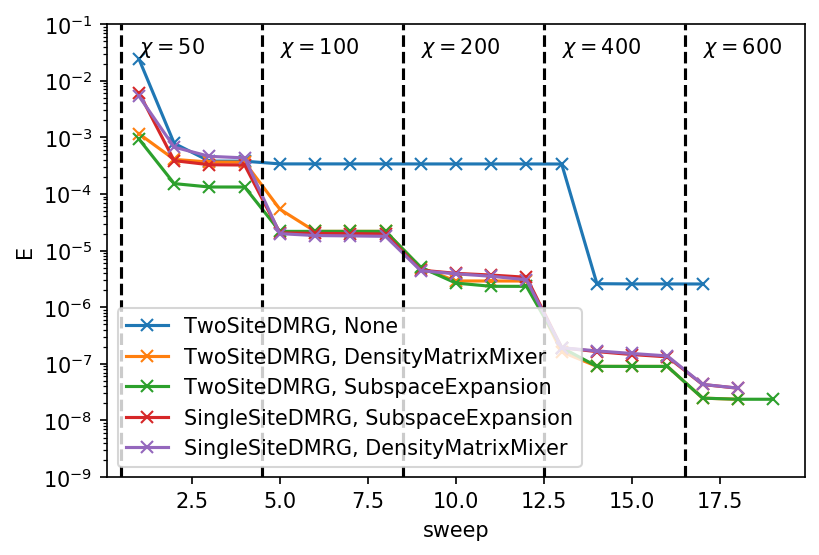

In [54]:
plt.figure(dpi=150)
ax = plt.gca()
for key, eng in engs.items():
    eng.plot_sweep_stats(ax, 'sweep', 'E', y_exact=E_exact, label=key)
for s, chi in eng.options['chi_list'].items():
    ax.axvline(s+0.5, linestyle='--', color='k')
    ax.text(s+1, 0.03, f"$\\chi={chi:d}$")
ax.set_ylim(1.e-9, 1.e-1)
plt.legend(loc='lower left')

### Reordering the MPS

The `'default'` geometry of the chain used above just has one very-long range coupling:

```
  F -- E
 /      \             .--------------------.                .--------------------. 
A        D    =>     /                      \      =>      /                      \ 
 \      /           A -- B -- C -- D -- E -- F            0 -- 1 -- 2 -- 3 -- 4 -- 5 
  B -- C 

 physical couplings           stretched                 chosen MPS orering 
``` 


In this particular case, another even better solution is to re-order the MPS to use the ``order='folded'`` of the `Chain`. In this case, we get at most next-nearest neighbor interactions in the MPS language, which DMRG can handle much better than the one very-long-range coupling:

```
  F -- E
 /      \               F -- E -- D                1 -- 3 -- 5
A        D        =>    |         |      =>        |         |
 \      /               A -- B -- C                0 -- 2 -- 3
  B -- C 

 physical couplings     stretched            chosen MPS orering 
```
The example below shows that this works with TwoSiteDMRG even with disabled mixer.
Nevertheless, I'd recommended to use the mixer in this case as well, since most couplings go beyond the local two sites you optimize at once.

In [48]:
L = 100
model_params = {
    'L': L, 'bc_MPS': 'finite', 
    'bc_x': 'periodic',
    'order': 'folded',
    'S': 1.,
}
M = SpinModel(model_params)
print(M.lat.order[:, 0])  # the order of MPS sites relative to original lattice indices

INFO    : SpinModel: reading 'bc_MPS'='finite'
INFO    : SpinModel: reading 'order'='folded'
INFO    : SpinModel: reading 'S'=1.0
INFO    : SpinModel: set conserve to Sz
INFO    : SpinModel: reading 'bc_x'='periodic'
INFO    : SpinModel: reading 'L'=100
[ 0 99  1 98  2 97  3 96  4 95  5 94  6 93  7 92  8 91  9 90 10 89 11 88 12 87 13 86 14 85 15 84 16
 83 17 82 18 81 19 80 20 79 21 78 22 77 23 76 24 75 25 74 26 73 27 72 28 71 29 70 30 69 31 68 32 67
 33 66 34 65 35 64 36 63 37 62 38 61 39 60 40 59 41 58 42 57 43 56 44 55 45 54 46 53 47 52 48 51 49
 50]


In [49]:
engs_reordered = {}
for mixer in [None, SubspaceExpansion]:
    eng = run_dmrg(TwoSiteDMRGEngine, mixer)
    key = "None" if mixer is None else mixer.__name__
    engs_reordered["TwoSiteDMRG, " + key] = eng

INFO    : TwoSiteDMRGEngine: reading 'chi_list'={0: 50, 4: 100, 8: 200, 12: 400, 16: 600}
INFO    : TwoSiteDMRGEngine: reading 'max_sweeps'=20
INFO    : TwoSiteDMRGEngine: reading 'mixer'=None
INFO    : Running sweep with optimization
INFO    : Setting chi_max=50
INFO    : trunc_params: setting 'chi_max'=50
INFO    : trunc_params: reading 'chi_max'=50
INFO    : checkpoint after sweep 1
energy=-131.8149615823249405, max S=1.3854464840636864, age=100, norm_err=8.5e-01
Current memory usage 2951.8MB, wall time: 2.2s
Delta E = nan, Delta S = 1.3508e+00 (per sweep)
max trunc_err = 0.0000e+00, max E_trunc = 1.4211e-13
chi: 9
INFO    : Running sweep with optimization
INFO    : checkpoint after sweep 2
energy=-140.0699355151413670, max S=1.6411373407976924, age=100, norm_err=9.2e-02
Current memory usage 2951.8MB, wall time: 19.6s
Delta E = -8.2550e+00, Delta S = 2.6853e-01 (per sweep)
max trunc_err = 5.3198e-06, max E_trunc = 4.5160e-05
chi: 50
INFO    : Running sweep with optimization
INFO    

INFO    : TwoSiteDMRGEngine: reading 'max_sweeps'=20
INFO    : TwoSiteDMRGEngine: reading 'mixer'=<class 'tenpy.algorithms.dmrg.SubspaceExpansion'>
INFO    : TwoSiteDMRGEngine: subconfig 'mixer_params'=Config(<3 options>, 'mixer_params')
INFO    : mixer_params: reading 'amplitude'=1e-06
INFO    : mixer_params: reading 'decay'=1.0
  warnings.warn("Mixer with decay=1. doesn't decay")

INFO    : mixer_params: reading 'disable_after'=18
INFO    : Running sweep with optimization
INFO    : Setting chi_max=50
INFO    : trunc_params: setting 'chi_max'=50
INFO    : trunc_params: reading 'chi_max'=50
INFO    : checkpoint after sweep 1
energy=-140.0324824463777418, max S=1.5915040250483667, age=100, norm_err=2.4e-01
Current memory usage 3264.4MB, wall time: 11.2s
Delta E = nan, Delta S = 1.5716e+00 (per sweep)
max trunc_err = 2.7515e-06, max E_trunc = 8.6015e-04
chi: 50
INFO    : Running sweep with optimization
INFO    : checkpoint after sweep 2
energy=-140.1077718870024853, max S=1.6816031117968

INFO    : checkpoint after sweep 19
energy=-140.1483984284970745, max S=1.7109565157624840, age=100, norm_err=3.1e-07
Current memory usage 3814.8MB, wall time: 39.6s
Delta E = -8.2089e-07, Delta S = -1.6068e-06 (per sweep)
max trunc_err = 3.8408e-09, max E_trunc = 3.6524e-08
chi: 600
INFO    : DMRG finished after 19 sweeps, max chi=600


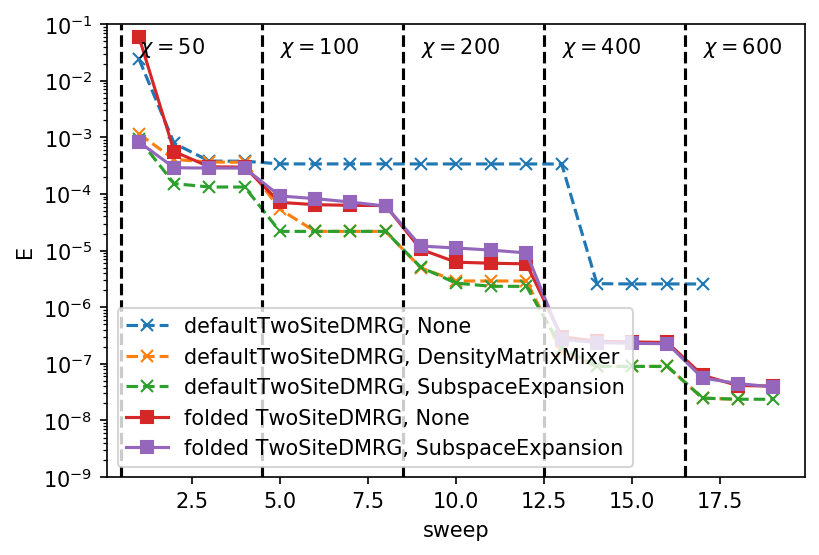

In [58]:
plt.figure(dpi=150)
ax = plt.gca()
for key, eng in engs.items():
    if not key.startswith('Two'):
        continue
    eng.plot_sweep_stats(ax, 'sweep', 'E', y_exact=E_exact, label='default' + key, linestyle='--')
for key, eng in engs_reordered.items():
    eng.plot_sweep_stats(ax, 'sweep', 'E', y_exact=E_exact, label='folded ' + key, marker='s')
for s, chi in eng.options['chi_list'].items():
    ax.axvline(s+0.5, linestyle='--', color='k')
    ax.text(s+1, 0.03, f"$\\chi={chi:d}$")
ax.set_ylim(1.e-9, 1.e-1)
plt.legend(loc='lower left')

## Infinite DMRG for next-nearest neighbors

In [12]:
L = 4
J, Jp = 0., 0.5  # purely next-nearest neighbors
model_params = {
    'Jx': J, 'Jy': J, 'Jz': 1.,
    'Jxp': Jp, 'Jyp': Jp, 'Jzp': Jp,
    'L': L, 'bc_MPS': 'infinite', 
    'conserve': 'Sz',
    'S': 1.
}
M = SpinChainNNN2(model_params)
E_exact_inf = -0.7610925710077936 # from running 2-site DMRG with mixer at chi=2000

INFO    : SpinChainNNN2: reading 'bc_MPS'='infinite'
INFO    : SpinChainNNN2: reading 'S'=1.0
INFO    : SpinChainNNN2: reading 'conserve'='Sz'
INFO    : SpinChainNNN2: reading 'L'=4
INFO    : SpinChainNNN2: reading 'Jx'=0.0
INFO    : SpinChainNNN2: reading 'Jy'=0.0
INFO    : SpinChainNNN2: reading 'Jz'=1.0
INFO    : SpinChainNNN2: reading 'Jxp'=0.5
INFO    : SpinChainNNN2: reading 'Jyp'=0.5
INFO    : SpinChainNNN2: reading 'Jzp'=0.5


In [25]:
dmrg_params = {
    'mixer': mixer,
    'mixer_params': {
        'amplitude': 1.e-6,
        'decay': 1.,
        'disable_after': 90,
    },
    'update_env': 0,
    'N_sweeps_check': 5,
    'max_sweeps': 100,
    'chi_list': {
        0: 50, 
        20: 100, 
        40: 200, 
        60: 400,
        80: 600,
    },
}

In [26]:
engs_inf = {}
for mixer in [None, DensityMatrixMixer, SubspaceExpansion]:
    eng = run_dmrg(TwoSiteDMRGEngine, mixer)
    key = "None" if mixer is None else mixer.__name__
    engs_inf["TwoSiteDMRG, " + key] = eng


  warnings.warn(msg.format(keys=sorted(unused), name=self.name))

INFO    : TwoSiteDMRGEngine: reading 'chi_list'={0: 50, 20: 100, 40: 200, 60: 400, 80: 600}
INFO    : start environment_sweep
INFO    : TwoSiteDMRGEngine: reading 'N_sweeps_check'=5
INFO    : TwoSiteDMRGEngine: reading 'max_sweeps'=100
INFO    : TwoSiteDMRGEngine: reading 'update_env'=0
INFO    : TwoSiteDMRGEngine: reading 'mixer'=None
INFO    : Running sweep with optimization
INFO    : Setting chi_max=50
INFO    : checkpoint after sweep 5
energy=-0.5000000000000000, max S=-0.0000000000000000, age=52, norm_err=0.0e+00
Current memory usage 2801.1MB, wall time: 0.3s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max trunc_err = 0.0000e+00, max E_trunc = 0.0000e+00
chi: [1, 1, 1, 1]
INFO    : Running sweep with optimization
INFO    : checkpoint after sweep 10
energy=-0.5000000000000000, max S=-0.0000000000000000, age=92, norm_err=0.0e+00
Current memory usage 2801.1MB, wall time: 0.3s
Delta E = 0.0000e+00, Delta S = 0.0000

INFO    : mixer_params: reading 'amplitude'=1e-06
INFO    : mixer_params: reading 'decay'=1.0
  warnings.warn("Mixer with decay=1. doesn't decay")

INFO    : mixer_params: reading 'disable_after'=90
INFO    : Running sweep with optimization
INFO    : Setting chi_max=50
INFO    : checkpoint after sweep 5
energy=-0.7579807674420609, max S=nan, age=52, norm_err=2.6e-01
Current memory usage 2801.1MB, wall time: 4.0s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max trunc_err = 9.5459e-05, max E_trunc = 2.0108e-04
chi: [50, 50, 50, 50]
INFO    : Running sweep with optimization
INFO    : checkpoint after sweep 10
energy=-0.7600635537831186, max S=nan, age=92, norm_err=7.8e-02
Current memory usage 2801.1MB, wall time: 2.1s
Delta E = -4.1656e-04, Delta S = 0.0000e+00 (per sweep)
max trunc_err = 1.0441e-04, max E_trunc = 2.3669e-04
chi: [50, 50, 50, 50]
INFO    : Running sweep with optimization
INFO    : checkpoint after sweep 15
energy=-0.7606698196662389, max S=nan, age=132, norm_err=2.9e-0

INFO    : TwoSiteDMRGEngine: subconfig 'mixer_params'=Config(<3 options>, 'mixer_params')
INFO    : mixer_params: reading 'amplitude'=1e-06
INFO    : mixer_params: reading 'decay'=1.0
  warnings.warn("Mixer with decay=1. doesn't decay")

INFO    : mixer_params: reading 'disable_after'=90
INFO    : Running sweep with optimization
INFO    : Setting chi_max=50
INFO    : checkpoint after sweep 5
energy=-0.7579930772978027, max S=nan, age=52, norm_err=2.6e-01
Current memory usage 2835.5MB, wall time: 4.7s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max trunc_err = 9.0391e-05, max E_trunc = 3.7506e-04
chi: [50, 50, 50, 50]
INFO    : Running sweep with optimization
INFO    : checkpoint after sweep 10
energy=-0.7600618560064518, max S=nan, age=92, norm_err=7.8e-02
Current memory usage 2835.5MB, wall time: 2.6s
Delta E = -4.1376e-04, Delta S = 0.0000e+00 (per sweep)
max trunc_err = 9.9615e-05, max E_trunc = 6.1476e-04
chi: [50, 50, 50, 50]
INFO    : Running sweep with optimization
INFO    :

In [28]:
for mixer in [SubspaceExpansion, DensityMatrixMixer]:
    eng = run_dmrg(SingleSiteDMRGEngine, mixer)
    key = mixer.__name__
    engs_inf["SingleSiteDMRG, " + key] = eng

INFO    : SingleSiteDMRGEngine: reading 'chi_list'={0: 50, 20: 100, 40: 200, 60: 400, 80: 600}
INFO    : start environment_sweep
INFO    : SingleSiteDMRGEngine: reading 'N_sweeps_check'=5
INFO    : SingleSiteDMRGEngine: reading 'max_sweeps'=100
INFO    : SingleSiteDMRGEngine: reading 'update_env'=0
INFO    : SingleSiteDMRGEngine: reading 'mixer'=<class 'tenpy.algorithms.dmrg.SubspaceExpansion'>
INFO    : SingleSiteDMRGEngine: subconfig 'mixer_params'=Config(<3 options>, 'mixer_params')
INFO    : mixer_params: reading 'amplitude'=1e-06
INFO    : mixer_params: reading 'decay'=1.0
  warnings.warn("Mixer with decay=1. doesn't decay")

INFO    : mixer_params: reading 'disable_after'=90
INFO    : Running sweep with optimization
INFO    : Setting chi_max=50
INFO    : checkpoint after sweep 5
energy=-0.7510261673359833, max S=nan, age=48, norm_err=3.8e-01
Current memory usage 2835.5MB, wall time: 1.7s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max trunc_err = 9.0478e-08, max E_trunc = 1.4

INFO    : DMRG finished after 90 sweeps, max chi=600
INFO    : SingleSiteDMRGEngine: reading 'chi_list'={0: 50, 20: 100, 40: 200, 60: 400, 80: 600}
INFO    : start environment_sweep
INFO    : SingleSiteDMRGEngine: reading 'N_sweeps_check'=5
INFO    : SingleSiteDMRGEngine: reading 'max_sweeps'=100
INFO    : SingleSiteDMRGEngine: reading 'update_env'=0
INFO    : SingleSiteDMRGEngine: reading 'mixer'=<class 'tenpy.algorithms.dmrg.DensityMatrixMixer'>
INFO    : SingleSiteDMRGEngine: subconfig 'mixer_params'=Config(<3 options>, 'mixer_params')
INFO    : mixer_params: reading 'amplitude'=1e-06
INFO    : mixer_params: reading 'decay'=1.0
  warnings.warn("Mixer with decay=1. doesn't decay")

INFO    : mixer_params: reading 'disable_after'=90
INFO    : Running sweep with optimization
INFO    : Setting chi_max=50
INFO    : checkpoint after sweep 5
energy=-0.7556209999636727, max S=nan, age=48, norm_err=2.5e-01
Current memory usage 2835.5MB, wall time: 2.0s
Delta E = nan, Delta S = 0.0000e+00 (pe

INFO    : Running sweep with optimization
INFO    : checkpoint after sweep 95
energy=-0.7610924964054817, max S=1.7621544090603831, age=768, norm_err=9.9e-04
Current memory usage 2951.8MB, wall time: 4.4s
Delta E = -5.9236e-10, Delta S = 1.9939e-05 (per sweep)
max trunc_err = 0.0000e+00, max E_trunc = 7.9581e-13
chi: [600, 600, 600, 600]
INFO    : Running sweep with optimization
INFO    : checkpoint after sweep 100
energy=-0.7610924924265845, max S=1.7621620430436364, age=808, norm_err=3.4e-04
Current memory usage 2951.8MB, wall time: 3.3s
Delta E = 7.9578e-10, Delta S = 1.6930e-06 (per sweep)
max trunc_err = 0.0000e+00, max E_trunc = 1.2506e-12
chi: [600, 600, 600, 600]
INFO    : DMRG finished after 100 sweeps, max chi=600


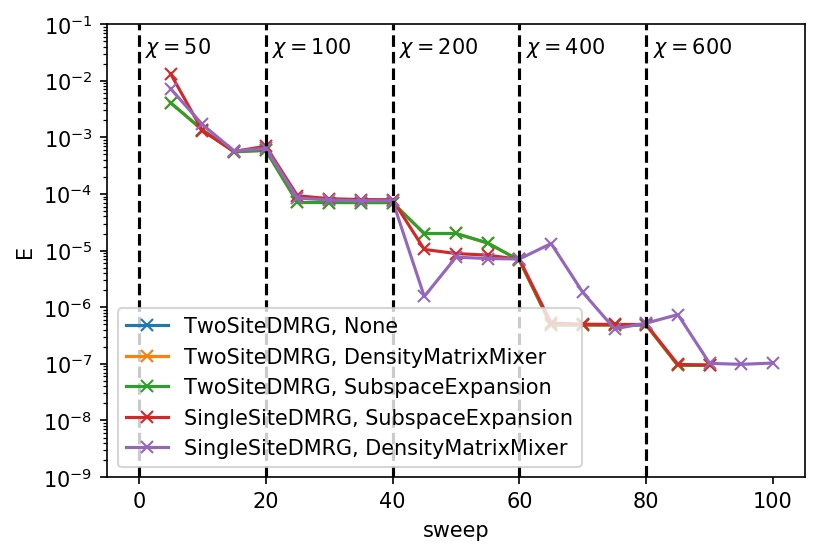

In [38]:
plt.figure(dpi=150)
ax = plt.gca()
for key, eng in engs_inf.items():
    eng.plot_sweep_stats(ax, 'sweep', 'E', y_exact=E_exact_inf, label=key)
for s, chi in eng.options['chi_list'].items():
    ax.axvline(s, linestyle='--', color='k')
    ax.text(s+1, 0.03, f"$\\chi={chi:d}$")
ax.set_ylim(1.e-9, 1.e-1)
plt.legend(loc='lower left')

Note: the fluctuations for the DensityMatrixMixer with SingleSIteDMRG are on the order of the mixer amplitude...